# DMRG-like Learning of a Compressed MPS Representation of a Matrix

In [1]:
import numpy as np
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import optax
from utils.jax_ops import *
from utils.scale_ordering import *
from utils.temporally_decaying_jets import initial_fields
import matplotlib.pyplot as plt

### TDJ Initial Flow as an Example Problem

In [2]:
n = 8
chi = 4

tdj = initial_fields(n=n)[0]
tdj_compressed = MPS(transform_tensor(tdj), max_bond=chi)

In [ ]:
initial_guess = np.random.random((2**n, 2**n))
initial_guess = MPS(transform_tensor(initial_guess), max_bond=4)

In [ ]:
def global_loss(A, A_MPS):
    val = jnp.mean((A - transform_tensor(contract_MPS(A_MPS))) ** 2)
    return val

In [ ]:
def local_loss(A, A_MPS, center, site):
    candidate = A_MPS.copy()
    candidate[site] = center
    val = jnp.mean((A - transform_tensor(contract_MPS(candidate))) ** 2)
    return val

Take a look at the loss we achieve with the SVD-based compression. This what we are trying to get close to.

In [6]:
starting_loss = global_loss(tdj, initial_guess)
compression_loss = global_loss(tdj, tdj_compressed)

print("The initial guess has a loss of", starting_loss)
print("The SVD-compressed version has a loss of", compression_loss)

The initial guess has a loss of 0.7962081041159353
The SVD-compressed version has a loss of 2.756897364830643e-06


### Local Optimization Using Adam

In [ ]:
# hyperparameters of the local optimization
start_learning_rate = 1e-1
local_precision = 1e-14
max_opt_steps = 250


def local_opt(A, A_MPS, site):
    # Bring mps into canonical form with center at "site".
    # NOTE: This is a suboptimal implementation as "canonicalize" loops through the whole mps.
    #       Single qr-decompositions are more efficient, but make the code convoluted and the adam
    #       steps are taking up by far the most time
    A_MPS = canonicalize(A_MPS, site)

    # We pick the canonical center to consider the entries as the optimization variables.
    center = A_MPS[site]

    optimizer = optax.adam(start_learning_rate)
    opt_state = optimizer.init(center)
    current = local_loss(A, A_MPS, center, site)
    for i in range(max_opt_steps):
        last = current

        # Define the gradient with respect to the entries of the center.
        grads = jax.grad(local_loss, argnums=2)(A, A_MPS, center, site)

        # Update the entries of the center.
        updates, opt_state = optimizer.update(grads, opt_state)
        center = optax.apply_updates(center, updates)

        # Break once the loss stops decreasing
        current = local_loss(A, A_MPS, center, site)
        if jnp.abs(current - last) < local_precision:
            break

    print("site:", site, ", opt_steps:", i, ", loss difference:", current - last)

    # Exchange the previous center with the optimized entries
    A_MPS[site] = center
    return A_MPS

### DMRG-like sweeping

In [8]:
def do_sweep(A, A_MPS):
    # Go right!
    for site in range(n - 1):
        A_MPS = local_opt(A, A_MPS, site)

    # Go left!
    for site in range(n - 1, 0, -1):
        A_MPS = local_opt(A, A_MPS, site)

    return A_MPS

### Sweeping Until the Loss is closs to the SVD-compression Loss

In [9]:
converged = False
last = starting_loss
factor = 1.1
desired_precision = max(compression_loss * 1.1, 1e-14)
print("Sweep until loss is below", desired_precision)

trial = initial_guess
goal = tdj

sweep = 0
max_sweeps = 3
while not converged and sweep < max_sweeps:
    trial = do_sweep(goal, trial)
    current = global_loss(goal, trial)
    converged = current < desired_precision
    print("coverged:", converged, ", sweep:", sweep, ", loss:", current)
    sweep += 1

Sweep until loss is below 3.0325871013137072e-06
site: 0 , opt_steps: 249 , loss difference: -0.0008511990798782954
site: 1 , opt_steps: 249 , loss difference: -0.0006083076679416766
site: 2 , opt_steps: 249 , loss difference: -0.0004021784497959813
site: 3 , opt_steps: 249 , loss difference: -3.961648899765413e-05
site: 4 , opt_steps: 249 , loss difference: -3.4502096854776426e-06
site: 5 , opt_steps: 249 , loss difference: -2.107949231833217e-14
site: 6 , opt_steps: 230 , loss difference: -3.909199353113735e-15
site: 7 , opt_steps: 141 , loss difference: -8.424684561081364e-15
site: 6 , opt_steps: 146 , loss difference: -6.17214612752548e-15
site: 5 , opt_steps: 132 , loss difference: -3.3688329903469594e-15
site: 4 , opt_steps: 173 , loss difference: -8.006616203370953e-15
site: 3 , opt_steps: 184 , loss difference: 3.131175874138137e-15
site: 2 , opt_steps: 249 , loss difference: -2.90632572668521e-13
site: 1 , opt_steps: 166 , loss difference: -4.713610449495146e-15
coverged: True

So it seems to converge at least sometimes. :) However if i increase chi, and therefore allow less compression, it seems to be performing worse. Could be, that im stopping the local optimizations to early.

Bond Dimensions:
(1, 4, 4, 4, 4, 4, 4, 4, 1)


overal performance measures:
         number of parameters full tensor:  65536
number of parameters matrix product state:  416
           relative size of MPS (rounded):  0.6 %
            mean relative error (rounded):  0.3 %


visual comparison


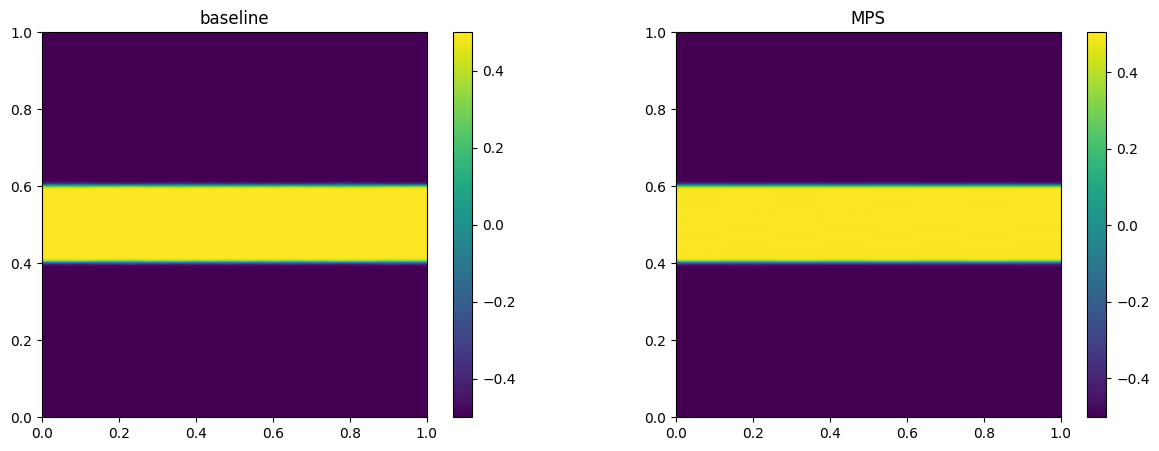

In [ ]:
def plot(A, B, title_a, title_b):
    extent = (0, 1, 0, 1)
    fig, axarr = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    true = axarr[0].imshow(
        A.T,
        extent=extent,
        origin="lower",
    )
    axarr[0].set_title(title_a)
    plt.colorbar(true, ax=axarr[0])

    mps = axarr[1].imshow(
        B.T,
        extent=extent,
        origin="lower",
    )
    axarr[1].set_title(title_b)
    plt.colorbar(mps, ax=axarr[1])


def show_measures(uncompressed, compressed):
    print("Bond Dimensions:")
    print(bond_dims_of_MPS(compressed))
    print()
    print()

    N_params_full = uncompressed.size
    N_params_mps = sum([core.size for core in compressed])
    print("overal performance measures:")
    print("         number of parameters full tensor: ", N_params_full)
    print("number of parameters matrix product state: ", N_params_mps)

    compression = N_params_mps / N_params_full
    compression = np.round(compression * 100, 1)
    mps_data = transform_tensor(contract_MPS(compressed))
    mean = np.sum(np.abs(uncompressed).mean()) / uncompressed.ndim
    RMSE = np.sqrt(((uncompressed - mps_data) ** 2).mean()) / uncompressed.ndim
    relative = np.round(RMSE / mean * 100, 1)
    print("           relative size of MPS (rounded): ", compression, "%")
    print("            mean relative error (rounded): ", relative, "%")
    print()
    print()

    print("visual comparison")
    plot(uncompressed, mps_data, "baseline", "MPS")


show_measures(tdj, trial)

### Example With Random Matrix

Sweep until loss is below 0.9670778848582331
site: 0 , opt_steps: 188 , loss difference: -7.16093850883226e-15
site: 1 , opt_steps: 166 , loss difference: 7.077671781985373e-16
site: 2 , opt_steps: 188 , loss difference: -2.831068712794149e-15
site: 3 , opt_steps: 169 , loss difference: -4.898859096158503e-15
site: 4 , opt_steps: 156 , loss difference: -6.38378239159465e-15
site: 5 , opt_steps: 145 , loss difference: 1.7069679003611782e-15
site: 6 , opt_steps: 164 , loss difference: 8.68749516769185e-15
site: 7 , opt_steps: 139 , loss difference: 6.328271240363392e-15
site: 6 , opt_steps: 155 , loss difference: 9.2148511043888e-15
site: 5 , opt_steps: 153 , loss difference: -2.3314683517128287e-15
site: 4 , opt_steps: 174 , loss difference: 5.093148125467906e-15
site: 3 , opt_steps: 168 , loss difference: -9.006684287271582e-15
site: 2 , opt_steps: 158 , loss difference: 3.982925100842749e-15
site: 1 , opt_steps: 180 , loss difference: 5.981326545168031e-15
coverged: True , sweep: 0 , 

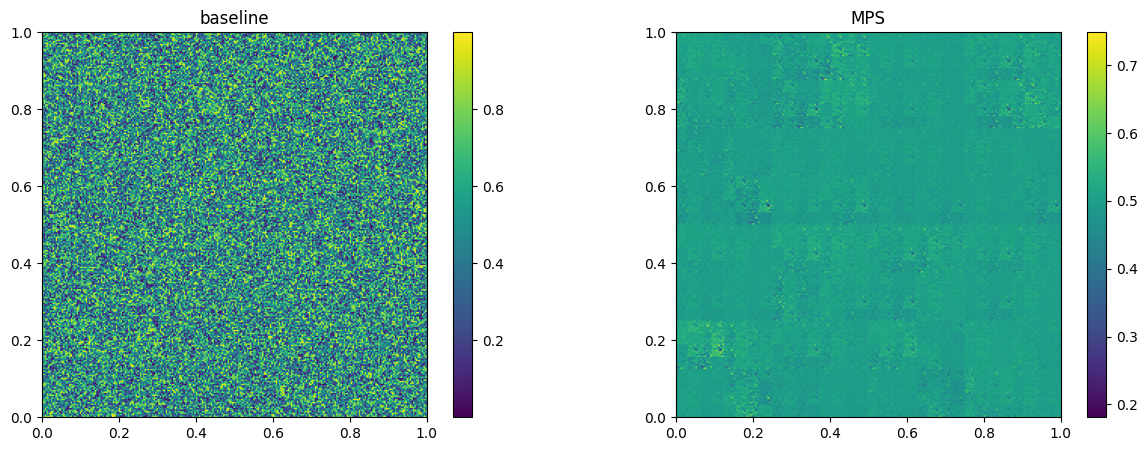

In [ ]:
converged = False
last = starting_loss
factor = 1.1

trial = initial_guess
goal = jnp.array(np.random.random((2**n, 2**n)))

random_compressed = MPS(transform_tensor(goal))
compression_loss = global_loss(tdj, random_compressed)

desired_precision = max(compression_loss * 1.1, 1e-10)
print("Sweep until loss is below", desired_precision)

sweep = 0
max_sweeps = 3
while not converged and sweep < max_sweeps:
    trial = do_sweep(goal, trial)
    current = global_loss(goal, trial)
    converged = current < desired_precision
    print("coverged:", converged, ", sweep:", sweep, ", loss:", current)
    sweep += 1

show_measures(goal, trial)

I guess this shows quite well, that a certain structure is very important for MPS to achieve a decent compression.